In [21]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import pandas as pd
from MatrixVectorizer import *
import torch
import random
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import seaborn as sns
import optuna

In [22]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Check for CUDA (GPU support) and set device accordingly
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # For multi-GPU setups
    # Additional settings for ensuring reproducibility on CUDA
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA not available. Using CPU.


In [23]:
LR_size = 160
HR_size = 268

# Load Data

In [24]:
def antivectorize_df(adj_mtx_df, size):
    
    num_subject = adj_mtx_df.shape[0]
    adj_mtx = np.zeros((num_subject, size, size)) #torch.zeros((num_subject, LR_size, LR_size))
    for i in range(num_subject):
        adj_mtx[i] = MatrixVectorizer.anti_vectorize(adj_mtx_df.iloc[i], size) # torch.from_numpy(MatrixVectorizer.anti_vectorize(A_LR_train.iloc[i], LR_size))
    return adj_mtx


# A_LR_train = pd.read_csv("../data/lr_train.csv")
# A_HR_train = pd.read_csv("../data/hr_train.csv")
# A_LR_test = pd.read_csv("../data/lr_test.csv")

# np.save('A_LR_train_matrix.npy', antivectorize_df(A_LR_train, LR_size))
# np.save('A_HR_train_matrix.npy', antivectorize_df(A_HR_train, HR_size))
# np.save('A_LR_test_matrix.npy', antivectorize_df(A_LR_test, LR_size))

In [25]:
A_LR_train_matrix = np.load('A_LR_train_matrix.npy')
A_HR_train_matrix = np.load('A_HR_train_matrix.npy')
A_LR_test_matrix = np.load("A_LR_test_matrix.npy")

print(A_LR_train_matrix.shape)
print(A_HR_train_matrix.shape)
print(A_LR_test_matrix.shape)

(167, 160, 160)
(167, 268, 268)
(112, 160, 160)


# Parameters

In [26]:
import numpy as np
import torch.optim as optim
from sklearn.model_selection import KFold
from preprocessing import *
from model import *
from train import *
import argparse



epochs = 200
lmbda = 20 # 16


parser = argparse.ArgumentParser(description='GSR-Net')
parser.add_argument('--epochs', type=int, default=epochs, metavar='no_epochs',
                help='number of episode to train ')
parser.add_argument('--lr', type=float, default=0.0001, metavar='lr',
                help='learning rate (default: 0.0001 using Adam Optimizer)')
parser.add_argument('--splits', type=int, default=3, metavar='n_splits',
                help='no of cross validation folds')
parser.add_argument('--lmbda', type=int, default=lmbda, metavar='L',
                help='self-reconstruction error hyperparameter')
parser.add_argument('--lr_dim', type=int, default=LR_size, metavar='N',
                help='adjacency matrix input dimensions')
parser.add_argument('--hr_dim', type=int, default=HR_size, metavar='N',
                help='super-resolved adjacency matrix output dimensions')
parser.add_argument('--hidden_dim', type=int, default=280, metavar='N',
                help='hidden GraphConvolutional layer dimensions')
parser.add_argument('--hidden_gat_dim', type=int, default=268, metavar='hidden_gat_dim',
                help='hidden GAT layer dimensions')
parser.add_argument('--padding', type=int, default=26, metavar='padding',
                help='dimensions of padding')
# parser.add_argument('--padding', type=int, default=26, metavar='padding',
#                 help='dimensions of padding')
parser.add_argument('--embedding_size', type=int, default=32, metavar='embedding_size',
                help='node embedding size')
parser.add_argument('--early_stop_patient', type=int, default=5, metavar='early_stop_patient',
                help='early_stop_patience')
parser.add_argument('--dropout_rate', type=float, default=0.2, metavar='dropout_rate',
                help='dropout_rate')
parser.add_argument('--p_perturbe', type=float, default=0.5, metavar='p_perturbe',
                help='p_perturbe')
parser.add_argument('--p_drop_node', type=float, default=0.03, metavar='p_drop_node',
                help='p_drop_node')
parser.add_argument('--p_drop_edges', type=float, default=0.1, metavar='p_drop_edges',
                help='p_drop_edges')

parser.add_argument('--mean_dense', type=float, default=0., metavar='mean',
                        help='mean of the normal distribution in Dense Layer')
parser.add_argument('--std_dense', type=float, default=0.01, metavar='std',
                    help='standard deviation of the normal distribution in Dense Layer')
parser.add_argument('--mean_gaussian', type=float, default=0., metavar='mean',
                    help='mean of the normal distribution in Gaussian Noise Layer')
parser.add_argument('--std_gaussian', type=float, default=0.1, metavar='std',
                    help='standard deviation of the normal distribution in Gaussian Noise Layer')



# Create an empty Namespace to hold the default arguments
args = parser.parse_args([]) 
print(args)

Namespace(epochs=200, lr=0.0001, splits=3, lmbda=20, lr_dim=160, hr_dim=268, hidden_dim=280, hidden_gat_dim=268, padding=26, embedding_size=32, early_stop_patient=5, dropout_rate=0.2, p_perturbe=0.5, p_drop_node=0.03, p_drop_edges=0.1, mean_dense=0.0, std_dense=0.01, mean_gaussian=0.0, std_gaussian=0.1)


In [27]:
# SIMULATING THE DATA: EDIT TO ENTER YOUR OWN DATA
X = A_LR_train_matrix #np.random.normal(0, 0.5, (167, 160, 160))
Y = A_HR_train_matrix #np.random.normal(0, 0.5, (167, 288, 288))
print(X.shape)
print(Y.shape)

(167, 160, 160)
(167, 268, 268)


In [28]:
device = get_device()
print(device)

mps


# Normalization

In [29]:
def compute_degree_matrix_normalization_batch_numpy(adjacency_batch):
    """
    Optimizes the degree matrix normalization for a batch of adjacency matrices using NumPy.
    Computes the normalized adjacency matrix D^-1 * A for each graph in the batch.
    
    Parameters:
    - adjacency_batch: A NumPy array of shape (batch_size, num_nodes, num_nodes) representing
                       a batch of adjacency matrices.

    Returns:
    - A NumPy array of normalized adjacency matrices.
    """
    epsilon = 1e-6  # Small constant to avoid division by zero
    # Calculate the degree for each node in the batch
    adjacency_batch = adjacency_batch + 2*np.eye(adjacency_batch.shape[1])
    d = adjacency_batch.sum(axis=2) + epsilon
    
    # Compute the inverse degree matrix D^-1 for the batch
    D_inv = np.reciprocal(d)[:, :, np.newaxis] * np.eye(adjacency_batch.shape[1])[np.newaxis, :, :]
    
    # Normalize the adjacency matrix using batch matrix multiplication
    normalized_adjacency_batch = np.matmul(D_inv, adjacency_batch)
    
    return normalized_adjacency_batch

def symmetric_norm(A):
    num_samples = A.shape[0]  # Number of samples, i.e., slices in the 3D tensor

    # Initialize an empty array for the normalized matrices
    A_normalized = np.zeros_like(A)

    for i in range(num_samples):
        # Extract the i-th adjacency matrix
        Ai = A[i, :, :]
        
        # Compute the degree matrix D and its inverse square root for Ai
        Di = np.diag(np.sum(Ai, axis=1))
        D_inv_sqrt_i = np.linalg.inv(np.sqrt(Di))
        
        # Normalize the adjacency matrix
        A_normalized[i, :, :] = D_inv_sqrt_i @ Ai @ D_inv_sqrt_i
    return A_normalized

def compute_pagerank_normalization(adjacency_matrices):
    """
    Normalizes each adjacency matrix in a batch using PageRank centrality values.
    
    Parameters:
    - adjacency_matrices: A NumPy array with shape (n_samples, n_dim, n_dim) representing the adjacency matrices.
    
    Returns:
    - A NumPy array of the same shape, with each adjacency matrix normalized.
    """
    n_samples, n_dim, _ = adjacency_matrices.shape
    normalized_matrices = np.zeros_like(adjacency_matrices)
    
    for i in tqdm(range(n_samples)):
        adjacency = adjacency_matrices[i]
        
        # Convert adjacency matrix to graph
        G = nx.from_numpy_array(adjacency, create_using=nx.DiGraph)
        
        # Compute PageRank
        pr_dict = nx.pagerank(G, alpha=0.85, max_iter=100, tol=1e-6)
        
        # Create a diagonal matrix with PageRank values
        pr_values = np.array([pr_dict[node] for node in range(n_dim)])
        pr_diag = np.diag(pr_values)
        
        # Normalize the adjacency matrix using the PageRank diagonal matrix
        normalized_adjacency = np.dot(pr_diag, adjacency)
        
        normalized_matrices[i] = normalized_adjacency
    
    return normalized_matrices
    

# X = compute_pagerank_normalization(X)
# A_LR_test_matrix = compute_pagerank_normalization(A_LR_test_matrix)

X = compute_degree_matrix_normalization_batch_numpy(X)
A_LR_test_matrix = compute_degree_matrix_normalization_batch_numpy(A_LR_test_matrix)

# X = symmetric_norm(X)
# A_LR_test_matrix = symmetric_norm(A_LR_test_matrix)

# print(X.shape)

In [30]:
# X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

best_mae = 1000
best_params = None
best_model = None

def hyperparameter_search(n_trials=40):
    def objective(trial):
        global best_mae
        global best_params
        global best_model
        ks = [0.8, 0.5]
        num_epochs = 200
        lr = trial.suggest_float('lr', 1e-6, 1e-2, log=True)
        lmbda = trial.suggest_int('lmbda', 1, 50)
        hidden_dim = trial.suggest_categorical('hidden_dim', [100, 200, 300, 400, 500])
        patience = trial.suggest_int('patience', 5, 20)
        dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.7, log=True)
        p_perturbe = trial.suggest_float('p_perturbe', 0, 0.7, step=0.1)
        p_drop_node = trial.suggest_float('p_drop_node', 0.01, 0.2, log=True)
        p_drop_edges = trial.suggest_float('p_drop_edges', 0.05, 0.2, log=True)


        args.epochs = num_epochs
        args.lr = lr
        args.lmbda = lmbda
        args.hidden_dim = hidden_dim
        args.early_stop_patient = patience
        args.dropout_rate = dropout_rate
        args.p_perturbe = p_perturbe
        args.p_drop_node = p_drop_node
        args.p_drop_edges = p_drop_edges

        params = {
                "lr": lr,
                "lmbda": lmbda,
                "hidden_dim": hidden_dim,
                "patience": patience,
                "dropout_rate": dropout_rate,
                "p_perturbe": p_perturbe,
                "p_drop_node": p_drop_node,
                "p_drop_edges": p_drop_edges,
            }
        print(f"Trial {trial.number}: {params}")

        cv = KFold(n_splits=args.splits, random_state=random_seed, shuffle=True)

        mae_list = []
        i = 1
        for train_index, test_index in cv.split(X):
            print(f"----- Fold {i} -----")
            subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = X[
                train_index], X[test_index], Y[train_index], Y[test_index]

            modelG = GSRNet(ks, args).to(device)
            optimizerG = torch.optim.Adam(modelG.parameters(), lr=args.lr)

            modelD = Discriminator(args).to(device)
            optimizerD = optim.Adam(modelD.parameters(), lr=args.lr)

            return_model = train_gan(modelG, optimizerG, modelD, optimizerD, subjects_adj, subjects_ground_truth, args, test_adj, test_ground_truth)
            test_mae = test(return_model, test_adj, test_ground_truth, args)
            mae_list.append(test_mae)

            i += 1

        mean_mae = np.mean(mae_list)
        if mean_mae < best_mae:
            best_mae = mean_mae
            best_params = params
            best_model = return_model
            print(f"New best MAE: {test_mae} with params: {best_params}")

        return mean_mae
    
    study = optuna.create_study(direction='minimize', study_name='GSR_hyperparameter_search', sampler=optuna.samplers.TPESampler())
    study.optimize(objective, n_trials=n_trials)
    return study.best_params

best_params = hyperparameter_search(100)

[I 2024-03-06 15:17:31,298] A new study created in memory with name: GSR_hyperparameter_search


Trial 0: {'lr': 0.00014005663314080547, 'lmbda': 27, 'hidden_dim': 500, 'patience': 13, 'dropout_rate': 0.40925991846405374, 'p_perturbe': 0.0, 'p_drop_node': 0.019031569584973363, 'p_drop_edges': 0.08722156242389797}
----- Fold 1 -----


Epoch Progress: 100%|██████████| 1/1 [00:11<00:00, 11.82s/epoch, test_error=0.181, train_error=0.223, train_loss=1.85]


----- Fold 2 -----


Epoch Progress: 100%|██████████| 1/1 [00:11<00:00, 11.73s/epoch, test_error=0.19, train_error=0.221, train_loss=1.88]


----- Fold 3 -----


Epoch Progress: 100%|██████████| 1/1 [00:11<00:00, 11.80s/epoch, test_error=0.186, train_error=0.221, train_loss=1.88]
[I 2024-03-06 15:18:16,811] Trial 0 finished with value: 0.1856362436918211 and parameters: {'lr': 0.00014005663314080547, 'lmbda': 27, 'hidden_dim': 500, 'patience': 13, 'dropout_rate': 0.40925991846405374, 'p_perturbe': 0.0, 'p_drop_node': 0.019031569584973363, 'p_drop_edges': 0.08722156242389797}. Best is trial 0 with value: 0.1856362436918211.


New best MAE: 0.186061046611179 with params: {'lr': 0.00014005663314080547, 'lmbda': 27, 'hidden_dim': 500, 'patience': 13, 'dropout_rate': 0.40925991846405374, 'p_perturbe': 0.0, 'p_drop_node': 0.019031569584973363, 'p_drop_edges': 0.08722156242389797}


# K-Fold cross validation

In [11]:
cv = KFold(n_splits=args.splits, random_state=random_seed, shuffle=True)

ks = [0.8, 0.5]

best_model_fold_list = []
data_fold_list = []
i = 1
for train_index, test_index in cv.split(X):

    print(f"----- Fold {i} -----")

    subjects_adj, test_adj, subjects_ground_truth, test_ground_truth = X[
        train_index], X[test_index], Y[train_index], Y[test_index]
    data_fold_list.append((subjects_adj, test_adj, subjects_ground_truth, test_ground_truth))


    netG = GSRNet(ks, args).to(device)
    optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

    netD = Discriminator(args).to(device)
    optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

    return_model = train_gan(
        netG, 
        optimizerG, 
        netD,
        optimizerD,
        subjects_adj, 
        subjects_ground_truth, 
        args, 
        test_adj=test_adj, 
        test_ground_truth=test_ground_truth
    )

    # return_model = train(netG, optimizerG, subjects_adj, subjects_ground_truth, args, test_adj, test_ground_truth)
    test_mae = test(return_model, test_adj, test_ground_truth, args)
    print(f"Val MAE: {test_mae}")
    best_model_fold_list.append(return_model)

    i += 1

----- Fold 1 -----


Epoch Progress:   0%|          | 0/200 [00:00<?, ?epoch/s]/Users/carlosbrat/Library/Mobile Documents/com~apple~CloudDocs/Imperial/Term2/Deep Graph-based Learning/CW2/graph_super_resolution/gsr_net/layers.py:35: UserWarning: The operator 'aten::_linalg_eigh.eigenvalues' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  eig_val_lr, U_lr = torch.linalg.eigh(lr, UPLO='U')
Epoch Progress:   3%|▎         | 6/200 [01:10<38:07, 11.79s/epoch, test_error=0.171, train_error=0.174, train_loss=3.42]


KeyboardInterrupt: 

In [ ]:
from MatrixVectorizer import MatrixVectorizer

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon
import torch
import networkx as nx

def evaluate(pred_matrices, gt_matrices, cal_graph=False):

    # pred_matrices = pred_matrices.cpu().detach().numpy()
    # gt_matrices = gt_matrices.cpu().detach().numpy()

    num_test_samples = gt_matrices.shape[0]

    # Initialize lists to store MAEs for each centrality measure
    mae_bc = []
    mae_ec = []
    mae_pc = []
    
    pred_1d = []
    gt_1d = []

    # Iterate over each test sample
    for i in tqdm(range(num_test_samples)):

        pred_1d.append(MatrixVectorizer.vectorize(pred_matrices[i]))
        gt_1d.append(MatrixVectorizer.vectorize(gt_matrices[i]))

        if cal_graph:
            # Convert adjacency matrices to NetworkX graphs
            pred_graph = nx.from_numpy_array(pred_matrices[i])
            gt_graph = nx.from_numpy_array(gt_matrices[i])

            # Compute centrality measures
            pred_bc = nx.betweenness_centrality(pred_graph, weight="weight")
            pred_ec = nx.eigenvector_centrality(pred_graph, weight="weight")
            pred_pc = nx.pagerank(pred_graph, weight="weight")

            gt_bc = nx.betweenness_centrality(gt_graph, weight="weight")
            gt_ec = nx.eigenvector_centrality(gt_graph, weight="weight")
            gt_pc = nx.pagerank(gt_graph, weight="weight")

            # Convert centrality dictionaries to lists
            pred_bc_values = list(pred_bc.values())
            pred_ec_values = list(pred_ec.values())
            pred_pc_values = list(pred_pc.values())

            gt_bc_values = list(gt_bc.values())
            gt_ec_values = list(gt_ec.values())
            gt_pc_values = list(gt_pc.values())

            # Compute MAEs
            mae_bc.append(mean_absolute_error(pred_bc_values, gt_bc_values))
            mae_ec.append(mean_absolute_error(pred_ec_values, gt_ec_values))
            mae_pc.append(mean_absolute_error(pred_pc_values, gt_pc_values))

    if cal_graph:
        # Compute average MAEs
        avg_mae_bc = sum(mae_bc) / len(mae_bc)
        avg_mae_ec = sum(mae_ec) / len(mae_ec)
        avg_mae_pc = sum(mae_pc) / len(mae_pc)

    # vectorize and flatten
    pred_1d = np.concatenate(pred_1d, axis=0).flatten()
    gt_1d = np.concatenate(gt_1d, axis=0).flatten()

    mae = mean_absolute_error(pred_1d, gt_1d)
    pcc = pearsonr(pred_1d, gt_1d)[0]
    js_dis = jensenshannon(pred_1d, gt_1d)

    print("MAE: ", mae)
    print("PCC: ", pcc)
    print("Jensen-Shannon Distance: ", js_dis)
    if cal_graph:
        print("Average MAE betweenness centrality:", avg_mae_bc)
        print("Average MAE eigenvector centrality:", avg_mae_ec)
        print("Average MAE PageRank centrality:", avg_mae_pc)

    if cal_graph:

        res = {
            "MAE": mae,
            "PCC": pcc,
            "JSD": js_dis,
            "MAE_(BC)": avg_mae_bc,
            "MAE_(EC)": avg_mae_ec,
            "MAE_(PC)": avg_mae_pc
        }
    else:
        res = {
            "MAE": mae,
            "PCC": pcc,
            "JSD": js_dis,
            # "MAE_(BC)": avg_mae_bc,
            # "MAE_(EC)": avg_mae_ec,
            # "MAE_(PC)": avg_mae_pc
        }

    return res



In [ ]:
res_list = []

for i in range(args.splits):
    _, test_adjs, _, gt_matrices = data_fold_list[i]
    model = best_model_fold_list[i]
    model.eval()
    pred_matrices = np.zeros(gt_matrices.shape)
    with torch.no_grad():
        for j, test_adj in enumerate(test_adjs):
            pred_matrices[j], _, _, _ = model(torch.from_numpy(test_adj))
    res_list.append(evaluate(pred_matrices, gt_matrices, cal_graph=False))

pd.DataFrame(res_list)

100%|██████████| 56/56 [00:00<00:00, 75.01it/s]


MAE:  0.1331318125532413
PCC:  0.6382396563770187
Jensen-Shannon Distance:  0.2843298892608118


100%|██████████| 56/56 [00:00<00:00, 77.19it/s]


MAE:  0.14506266190815634
PCC:  0.5938296665594252
Jensen-Shannon Distance:  0.30119436667206106


100%|██████████| 55/55 [00:00<00:00, 94.02it/s]


MAE:  0.139692404669245
PCC:  0.6129086784725483
Jensen-Shannon Distance:  0.29030578028209403


,MAE,PCC,JSD
0,0.133132,0.638240,0.284330
1,0.145063,0.593830,0.301194
2,0.139692,0.612909,0.290306


In [ ]:
# res_list = []

# for i in range(args.splits):
#     _, test_adjs, _, gt_matrices = data_fold_list[i]
#     model = best_model_fold_list[i]
#     model.eval()
#     pred_matrices = np.zeros(gt_matrices.shape)
#     with torch.no_grad():
#         for j, test_adj in enumerate(test_adjs):
#             pred_matrices[j], _, _, _ = model(torch.from_numpy(test_adj))
#     res_list.append(evaluate(pred_matrices, gt_matrices))

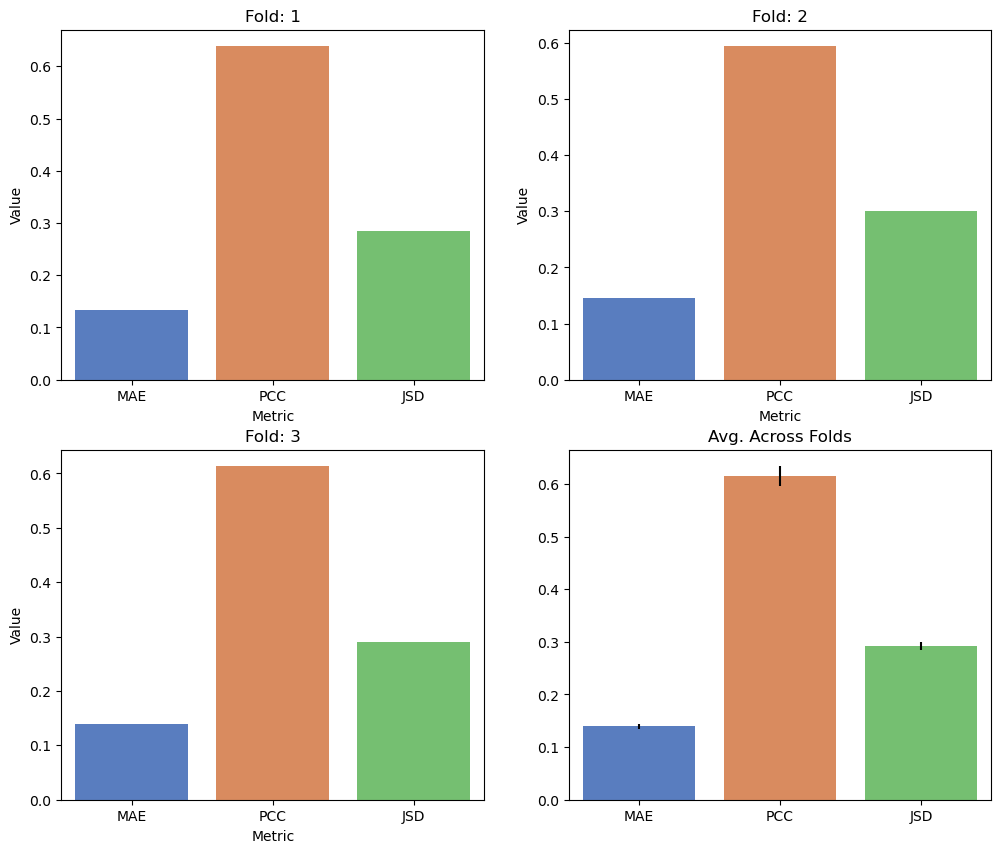

In [ ]:
def plot_metrics_fold(res_list):
    df = pd.DataFrame(res_list)
    df = df.rename(columns={"mae": "MAE", "pcc": "PCC", "js_dis": "JSD", "avg_mae_bc": "MAE_(BC)", "avg_mae_ec": "MAE_(EC)", "avg_mae_pc": "MAE_(PC)"})
    df.index = df.index.set_names(['Fold'])
    df.loc['mean'] = df.mean()
    avg_data = df.iloc[-1, :]
    df.loc['std'] = df.std()
    errors = df.iloc[-1, :].tolist()
    df = df.reset_index()
    df = df.iloc[:-2, :]
    df_long = df.melt(id_vars='Fold', var_name='Metric', value_name='Value')
    palette = sns.color_palette("muted", n_colors=len(df_long['Metric'].unique()))
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    for fold in range(3):   
        i = fold // 2
        j = fold % 2
        sns.barplot(x='Metric', y='Value', data=df_long[df_long['Fold'] == fold], ax=axs[i, j], palette=palette)
        axs[i, j].set_title(f"Fold: {fold+1}")

    sns.barplot(x=avg_data.index, y=avg_data.values, ax=axs[1, 1], palette=palette, yerr=errors, capsize=5)
    axs[1, 1].set_title("Avg. Across Folds")
    plt.show()

plot_metrics_fold(res_list)


# Split train and validation

In [ ]:
A_HR_train = pd.read_csv("../data/hr_train.csv")

pca = PCA(n_components=0.99, whiten=False)
A_HR_train_pca = pca.fit_transform(A_HR_train)
print(A_HR_train_pca.shape)

gm = GaussianMixture(n_components=5, random_state=random_seed)
A_HR_train_label = gm.fit_predict(A_HR_train_pca)
unique, counts = np.unique(A_HR_train_label, return_counts=True)
print(np.asarray((unique, counts)).T)

X = np.load('A_LR_train_matrix.npy')
y = np.load('A_HR_train_matrix.npy')

n_sample = X.shape[0]
X_train, X_val, y_train, y_val = train_test_split(
    X.reshape(n_sample, -1), 
    y.reshape(n_sample, -1), 
    test_size=0.20, 
    random_state=random_seed,
    stratify=A_HR_train_label
)

X_train = X_train.reshape(-1, LR_size, LR_size)
X_val = X_val.reshape(-1, LR_size, LR_size)
y_train = y_train.reshape(-1, HR_size, HR_size)
y_val = y_val.reshape(-1, HR_size, HR_size)

print("Train size:", len(X_train))
print("Val size:", len(X_val))



(167, 161)
[[ 0 14]
 [ 1 30]
 [ 2 30]
 [ 3 46]
 [ 4 47]]
Train size: 133
Val size: 34


# Train Final Model

In [ ]:
netG = GSRNet(ks, args).to(device)
optimizerG = optim.Adam(netG.parameters(), lr=args.lr)

netD = Discriminator(args).to(device)
optimizerD = optim.Adam(netD.parameters(), lr=args.lr)

final_model = train_gan(
    netG, 
    optimizerG, 
    netD,
    optimizerD,
    X_train, 
    y_train, 
    args, 
    test_adj=X_val, 
    test_ground_truth=y_val
)
# final_model = train(netG, optimizerG, X_train, y_train, args, X_val, y_val)

Epoch Progress:   0%|          | 1/200 [00:21<1:12:31, 21.86s/epoch]

Epoch: 1, Train Loss: 2.318177, Train Error: 0.239236, Test Error: 0.201087


Epoch Progress:   1%|          | 2/200 [00:43<1:11:29, 21.66s/epoch]

Epoch: 2, Train Loss: 1.373000, Train Error: 0.179409, Test Error: 0.171412


Epoch Progress:   2%|▏         | 3/200 [01:04<1:10:23, 21.44s/epoch]

Epoch: 3, Train Loss: 2.043321, Train Error: 0.172138, Test Error: 0.169621


Epoch Progress:   2%|▏         | 4/200 [01:26<1:10:02, 21.44s/epoch]

Epoch: 4, Train Loss: 3.160346, Train Error: 0.170658, Test Error: 0.168626


Epoch Progress:   2%|▎         | 5/200 [01:48<1:10:20, 21.64s/epoch]

Epoch: 5, Train Loss: 4.064565, Train Error: 0.169422, Test Error: 0.167576


Epoch Progress:   3%|▎         | 6/200 [02:09<1:09:33, 21.51s/epoch]

Epoch: 6, Train Loss: 4.681620, Train Error: 0.168084, Test Error: 0.166366


Epoch Progress:   4%|▎         | 7/200 [02:30<1:09:18, 21.54s/epoch]

Epoch: 7, Train Loss: 5.034149, Train Error: 0.166384, Test Error: 0.164648


Epoch Progress:   4%|▍         | 8/200 [02:52<1:09:13, 21.63s/epoch]

Epoch: 8, Train Loss: 5.156408, Train Error: 0.164507, Test Error: 0.162674


Epoch Progress:   4%|▍         | 9/200 [03:14<1:08:43, 21.59s/epoch]

Epoch: 9, Train Loss: 5.144561, Train Error: 0.162346, Test Error: 0.160598


Epoch Progress:   5%|▌         | 10/200 [03:35<1:08:24, 21.60s/epoch]

Epoch: 10, Train Loss: 4.969817, Train Error: 0.160112, Test Error: 0.158092


Epoch Progress:   6%|▌         | 11/200 [03:57<1:08:04, 21.61s/epoch]

Epoch: 11, Train Loss: 4.776209, Train Error: 0.158107, Test Error: 0.156530


Epoch Progress:   6%|▌         | 12/200 [04:18<1:07:27, 21.53s/epoch]

Epoch: 12, Train Loss: 4.736135, Train Error: 0.156166, Test Error: 0.155112


Epoch Progress:   6%|▋         | 13/200 [04:40<1:07:27, 21.64s/epoch]

Epoch: 13, Train Loss: 4.898272, Train Error: 0.154277, Test Error: 0.152992


Epoch Progress:   7%|▋         | 14/200 [05:02<1:07:34, 21.80s/epoch]

Epoch: 14, Train Loss: 5.195133, Train Error: 0.152460, Test Error: 0.151691


Epoch Progress:   8%|▊         | 15/200 [05:24<1:06:55, 21.70s/epoch]

Epoch: 15, Train Loss: 5.472997, Train Error: 0.150994, Test Error: 0.150551


Epoch Progress:   8%|▊         | 16/200 [05:46<1:06:38, 21.73s/epoch]

Epoch: 16, Train Loss: 5.789949, Train Error: 0.149465, Test Error: 0.149240


Epoch Progress:   8%|▊         | 17/200 [06:07<1:05:52, 21.60s/epoch]

Epoch: 17, Train Loss: 6.088707, Train Error: 0.147930, Test Error: 0.147657


Epoch Progress:   9%|▉         | 18/200 [06:29<1:05:39, 21.64s/epoch]

Epoch: 18, Train Loss: 6.366004, Train Error: 0.146474, Test Error: 0.146717


Epoch Progress:  10%|▉         | 19/200 [06:50<1:05:05, 21.58s/epoch]

Epoch: 19, Train Loss: 6.717819, Train Error: 0.145321, Test Error: 0.146096


Epoch Progress:  10%|█         | 20/200 [07:12<1:04:36, 21.54s/epoch]

Epoch: 20, Train Loss: 6.989245, Train Error: 0.144352, Test Error: 0.144903


Epoch Progress:  10%|█         | 21/200 [07:33<1:04:15, 21.54s/epoch]

Epoch: 21, Train Loss: 7.269018, Train Error: 0.143450, Test Error: 0.143824


Epoch Progress:  11%|█         | 22/200 [07:54<1:03:41, 21.47s/epoch]

Epoch: 22, Train Loss: 7.557467, Train Error: 0.142552, Test Error: 0.142777


Epoch Progress:  12%|█▏        | 23/200 [08:16<1:03:09, 21.41s/epoch]

Epoch: 23, Train Loss: 7.835352, Train Error: 0.141495, Test Error: 0.141689


Epoch Progress:  12%|█▏        | 24/200 [08:37<1:03:00, 21.48s/epoch]

Epoch: 24, Train Loss: 8.078742, Train Error: 0.140585, Test Error: 0.141478


Epoch Progress:  12%|█▎        | 25/200 [08:59<1:02:40, 21.49s/epoch]

Epoch: 25, Train Loss: 8.309034, Train Error: 0.139755, Test Error: 0.141179


Epoch Progress:  13%|█▎        | 26/200 [09:20<1:02:09, 21.44s/epoch]

Epoch: 26, Train Loss: 8.447239, Train Error: 0.139047, Test Error: 0.140295


Epoch Progress:  14%|█▎        | 27/200 [09:46<1:05:57, 22.88s/epoch]

Epoch: 27, Train Loss: 8.576740, Train Error: 0.138279, Test Error: 0.139830


Epoch Progress:  14%|█▍        | 28/200 [10:11<1:07:21, 23.50s/epoch]

Epoch: 28, Train Loss: 8.670612, Train Error: 0.137507, Test Error: 0.139399


Epoch Progress:  14%|█▍        | 29/200 [14:46<4:41:42, 98.84s/epoch]

Epoch: 29, Train Loss: 8.751353, Train Error: 0.136793, Test Error: 0.139111


Epoch Progress:  15%|█▌        | 30/200 [15:11<3:37:39, 76.82s/epoch]

Epoch: 30, Train Loss: 8.847031, Train Error: 0.136223, Test Error: 0.138823


Epoch Progress:  16%|█▌        | 31/200 [15:33<2:49:44, 60.26s/epoch]

Epoch: 31, Train Loss: 8.904030, Train Error: 0.135874, Test Error: 0.138194


Epoch Progress:  16%|█▌        | 32/200 [15:55<2:16:35, 48.78s/epoch]

Epoch: 32, Train Loss: 8.956477, Train Error: 0.135639, Test Error: 0.137698


Epoch Progress:  16%|█▋        | 33/200 [16:17<1:53:03, 40.62s/epoch]

Epoch: 33, Train Loss: 9.105234, Train Error: 0.135108, Test Error: 0.136736


Epoch Progress:  17%|█▋        | 34/200 [16:38<1:36:41, 34.95s/epoch]

Epoch: 34, Train Loss: 9.112586, Train Error: 0.134347, Test Error: 0.136334


Epoch Progress:  18%|█▊        | 35/200 [17:00<1:25:20, 31.04s/epoch]

Epoch: 35, Train Loss: 9.085787, Train Error: 0.133900, Test Error: 0.136320


Epoch Progress:  18%|█▊        | 36/200 [17:22<1:17:33, 28.38s/epoch]

Epoch: 36, Train Loss: 9.162064, Train Error: 0.133582, Test Error: 0.136603


Epoch Progress:  18%|█▊        | 37/200 [17:44<1:11:41, 26.39s/epoch]

Epoch: 37, Train Loss: 9.172298, Train Error: 0.132872, Test Error: 0.136162


Epoch Progress:  19%|█▉        | 38/200 [18:06<1:07:39, 25.06s/epoch]

Epoch: 38, Train Loss: 9.149638, Train Error: 0.132187, Test Error: 0.135940


Epoch Progress:  20%|█▉        | 39/200 [18:28<1:04:31, 24.05s/epoch]

Epoch: 39, Train Loss: 9.121087, Train Error: 0.131607, Test Error: 0.135560


Epoch Progress:  20%|██        | 40/200 [18:49<1:02:11, 23.32s/epoch]

Epoch: 40, Train Loss: 9.059390, Train Error: 0.131038, Test Error: 0.135902


Epoch Progress:  20%|██        | 41/200 [19:13<1:02:05, 23.43s/epoch]

Epoch: 41, Train Loss: 9.041131, Train Error: 0.130615, Test Error: 0.135578


Epoch Progress:  21%|██        | 42/200 [35:42<13:44:37, 313.15s/epoch]

Epoch: 42, Train Loss: 9.057712, Train Error: 0.130595, Test Error: 0.135536


Epoch Progress:  22%|██▏       | 43/200 [36:41<10:19:31, 236.76s/epoch]

Epoch: 43, Train Loss: 9.218403, Train Error: 0.130689, Test Error: 0.135792


Epoch Progress:  22%|██▏       | 44/200 [38:38<8:42:33, 200.98s/epoch] 

Epoch: 44, Train Loss: 9.379411, Train Error: 0.130557, Test Error: 0.135822


Epoch Progress:  22%|██▎       | 45/200 [44:08<10:19:07, 239.66s/epoch]

Epoch: 45, Train Loss: 9.388696, Train Error: 0.130099, Test Error: 0.135396


Epoch Progress:  23%|██▎       | 46/200 [50:23<11:59:13, 280.22s/epoch]

Epoch: 46, Train Loss: 9.469347, Train Error: 0.129917, Test Error: 0.134624


Epoch Progress:  24%|██▎       | 47/200 [1:16:25<28:15:07, 664.76s/epoch]

Epoch: 47, Train Loss: 9.502012, Train Error: 0.129402, Test Error: 0.134346


Epoch Progress:  24%|██▍       | 48/200 [1:18:14<21:01:27, 497.94s/epoch]

Epoch: 48, Train Loss: 9.692938, Train Error: 0.129276, Test Error: 0.134480


Epoch Progress:  24%|██▍       | 49/200 [1:18:37<14:54:53, 355.59s/epoch]

Epoch: 49, Train Loss: 9.830607, Train Error: 0.129308, Test Error: 0.134226


Epoch Progress:  25%|██▌       | 50/200 [1:18:59<10:38:42, 255.48s/epoch]

Epoch: 50, Train Loss: 9.986336, Train Error: 0.128877, Test Error: 0.134132


Epoch Progress:  26%|██▌       | 51/200 [1:19:21<7:40:37, 185.48s/epoch] 

Epoch: 51, Train Loss: 10.024916, Train Error: 0.128336, Test Error: 0.134210


Epoch Progress:  26%|██▌       | 52/200 [1:19:45<5:37:32, 136.84s/epoch]

Epoch: 52, Train Loss: 10.117257, Train Error: 0.128175, Test Error: 0.133975


Epoch Progress:  26%|██▋       | 53/200 [1:20:08<4:11:37, 102.71s/epoch]

Epoch: 53, Train Loss: 10.011216, Train Error: 0.127780, Test Error: 0.134264


Epoch Progress:  27%|██▋       | 54/200 [1:20:34<3:13:52, 79.67s/epoch] 

Epoch: 54, Train Loss: 9.956398, Train Error: 0.127358, Test Error: 0.134428


Epoch Progress:  28%|██▊       | 55/200 [1:21:01<2:34:46, 64.05s/epoch]

Epoch: 55, Train Loss: 9.904143, Train Error: 0.127243, Test Error: 0.134364


Epoch Progress:  28%|██▊       | 56/200 [1:21:25<2:04:32, 51.89s/epoch]

Epoch: 56, Train Loss: 9.795807, Train Error: 0.127133, Test Error: 0.134277


Epoch Progress:  28%|██▊       | 57/200 [1:21:49<1:43:35, 43.47s/epoch]

Epoch: 57, Train Loss: 9.761261, Train Error: 0.126785, Test Error: 0.134085


Epoch Progress:  28%|██▊       | 57/200 [1:22:16<3:26:25, 86.61s/epoch]

Val Error: 0.133975


In [ ]:
final_model.eval()
pred_train_matrices = np.zeros(y_train.shape)
pred_val_matrices = np.zeros(y_val.shape)
with torch.no_grad():
    for j, test_adj in enumerate(X_train):
        pred_train_matrices[j], _, _, _ = final_model(torch.from_numpy(test_adj))

    print("Train")
    evaluate(pred_train_matrices, y_train)

    for j, test_adj in enumerate(X_val):
        pred_val_matrices[j], _, _, _ = final_model(torch.from_numpy(test_adj))

    print("Val")
    evaluate(pred_val_matrices, y_val)

Train


100%|██████████| 133/133 [00:01<00:00, 81.55it/s]


MAE:  0.1285266478863747
PCC:  0.6745766270363869
Jensen-Shannon Distance:  0.27543885189030015
Val


100%|██████████| 34/34 [00:00<00:00, 92.69it/s]


MAE:  0.13397503231917554
PCC:  0.6461689894033666
Jensen-Shannon Distance:  0.27788996009861194


# Predict Test Set

In [ ]:
output_pred_list = []
final_model.eval()
with torch.no_grad():
    for i in range(A_LR_test_matrix.shape[0]):
        output_pred, _, _, _ = final_model(torch.Tensor(A_LR_test_matrix[i]))
        output_pred = MatrixVectorizer.vectorize(output_pred).tolist()
        output_pred_list.append(output_pred)

In [ ]:
output_pred_stack = np.stack(output_pred_list, axis=0)
output_pred_1d = output_pred_stack.flatten()
assert output_pred_1d.shape == (4007136, )

In [ ]:
df = pd.DataFrame({
    "ID": [i+1 for i in range(len(output_pred_1d))],
    "Predicted": output_pred_1d.tolist()
})

df

,ID,Predicted
0,1,0.585028
1,2,0.496612
2,3,0.694167
3,4,0.536072
4,5,0.502271
...,...,...
4007131,4007132,0.000000
4007132,4007133,0.019808
4007133,4007134,0.272116
4007134,4007135,0.090878


In [ ]:
df.to_csv("gsr_gan_gat_relu.csv", index=False)